# Import necessary libraries

In [1]:
%config Completer.use_jedi = False

In [2]:
# Standard python libraries
import logging
import os
import time
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Installed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

from lightautoml.addons.uplift import meta_learners
from lightautoml.addons.uplift.metrics import (_available_uplift_modes,
                                               calculate_graphic_uplift_curve,
                                               calculate_min_max_uplift_auc,
                                               calculate_uplift_auc,
                                               perfect_uplift_curve)
from lightautoml.report.report_deco import ReportDecoUplift


%matplotlib inline

# Parameters

## Setting

In [3]:
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 300 # Time in seconds for automl run
TARGET_NAME = 'TARGET' # Target column name
TREATMENT_NAME = 'TREATMENT' # Treatment column name

## Fix torch number of threads and numpy seed

In [4]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Example data load

In [5]:
%%time

data = pd.read_csv('./example_data/test_data_files/sampled_app_train.csv')
data.head()

CPU times: user 76.4 ms, sys: 6.48 ms, total: 82.9 ms
Wall time: 82.5 ms


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


# (Optional) Some user feature preparation

In [6]:
%%time 

data['BIRTH_DATE'] = (np.datetime64('2018-01-01') + data['DAYS_BIRTH'].astype(np.dtype('timedelta64[D]'))).astype(str)
data['EMP_DATE'] = (np.datetime64('2018-01-01') + np.clip(data['DAYS_EMPLOYED'], None, 0).astype(np.dtype('timedelta64[D]'))
                    ).astype(str)

data['report_dt'] = np.datetime64('2018-01-01')

data['constant'] = 1
data['allnan'] = np.nan

data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)

CPU times: user 80.7 ms, sys: 4.1 ms, total: 84.8 ms
Wall time: 83.8 ms


# Create treatment column with synthetic values (only for example)

In [7]:
%%time 

data[TREATMENT_NAME] = np.nan
data.loc[data[TARGET_NAME] == 0, TREATMENT_NAME] = \
    np.random.randint(2, size=data.loc[data[TARGET_NAME] == 0].shape[0])
data.loc[data[TARGET_NAME] == 1, TREATMENT_NAME] = \
    np.random.choice([0, 1], data[data[TARGET_NAME] == 1].shape[0], p=[0.3, 0.7])

CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 9.28 ms


# (Optional) Data splitting for train-test

In [8]:
%%time

train, test = train_test_split(data, test_size=2000, random_state=42, shuffle=True)

test_target, test_treatment = test[TARGET_NAME].values.ravel(), test[TREATMENT_NAME].values.ravel()

CPU times: user 5.42 ms, sys: 0 ns, total: 5.42 ms
Wall time: 5.15 ms


# Setup columns roles

In [9]:
%%time

roles = {
    'target': TARGET_NAME,
    'treatment': TREATMENT_NAME,
    DatetimeRole(base_date=True, seasonality=(), base_feats=False): 'report_dt'
}

CPU times: user 73 µs, sys: 27 µs, total: 100 µs
Wall time: 102 µs


# Uplift modeling

## TLearner

### Fit on train data

In [10]:
%%time

# Default setting
tlearner = meta_learners.TLearner(base_task=Task('binary'))
tlearner.fit(train, roles)

Train data shape: (4126, 125)
Feats was rejected during automatic roles guess: ['FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'NAME_TYPE_SUITE']


Layer 1 ...
Train process start. Time left 9999999996.545176 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
Linear model: C = 1e-05 score = 0.6811692927378272
Linear model: C = 5e-05 score = 0.7071733206966
Linear model: C = 0.0001 score = 0.7262320815069304
Linear model: C = 0.0005 score = 0.7715318090273664
Linear model: C = 0.001 score = 0.7800616040753465
Linear model: C = 0.005 score = 0.7778847292974767
Linear model: C = 0.01 score = 0.7718872171543656
Linear model: C = 1e-05 score = 0.6514507291074048
Linear model: C = 5e-05 score = 0.6661975626553283
Linear model: C = 0.0001 score = 0.6793574273138305
Linear model: C = 0.0005 score = 0.7096445788543881
Linear model: C = 0.001 score = 0.7198850196125401
Linear model: C = 0.005 score = 0.72

## Predict to test data and check metrics

In [11]:
%%time

uplift_pred, treatment_pred, control_pred = tlearner.predict(test)
uplift_pred = uplift_pred.ravel()

roc_auc_treatment = roc_auc_score(test_target[test_treatment == 1], treatment_pred[test_treatment == 1])
roc_auc_control = roc_auc_score(test_target[test_treatment == 0], control_pred[test_treatment == 0])

uplift_auc_algo = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=False)
uplift_auc_algo_normed = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=True)
auc_base, auc_perfect = calculate_min_max_uplift_auc(test_target, test_treatment)

logging.info('--- Check scores ---')
logging.info('OOF scores "ROC_AUC":')
logging.info('\tTreatment = %f', roc_auc_treatment)
logging.info('\tControl   = %f', roc_auc_control)
logging.info('Uplift score of test group (default="adj_qini"):')
logging.info('\tBaseline      = %f', auc_base)
logging.info('\tAlgo (Normed) = %f (%f)', uplift_auc_algo, uplift_auc_algo_normed)
logging.info('\tPerfect       = %f', auc_perfect)

[2021-02-15 15:52:10,467] (INFO): --- Check scores ---
[2021-02-15 15:52:10,467] (INFO): OOF scores "ROC_AUC":
[2021-02-15 15:52:10,468] (INFO): 	Treatment = 0.713348
[2021-02-15 15:52:10,468] (INFO): 	Control   = 0.710596
[2021-02-15 15:52:10,468] (INFO): Uplift score of test group (default="adj_qini"):
[2021-02-15 15:52:10,469] (INFO): 	Baseline      = 0.027138
[2021-02-15 15:52:10,469] (INFO): 	Algo (Normed) = 0.032045 (0.332049)
[2021-02-15 15:52:10,469] (INFO): 	Perfect       = 0.096506


CPU times: user 992 ms, sys: 0 ns, total: 992 ms
Wall time: 744 ms


## XLearner

### Fit on train data

In [12]:
%%time

# Custom base algorithm
xlearner = meta_learners.XLearner(
    propensity_learner=TabularAutoML(task=Task('binary'), timeout=30),
    outcome_learners=[
        TabularAutoML(task=Task('binary'), timeout=30),
        TabularAutoML(task=Task('binary'), timeout=30)
    ],
    effect_learners=[
        TabularAutoML(task=Task('reg'), timeout=30),
        TabularAutoML(task=Task('reg'), timeout=30)
    ]
)
xlearner.fit(train, roles)

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start automl preset with listed constraints:
- time: 30 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (8000, 125)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 28.684314250946045 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
Linear model: C = 1e-05 score = 0.5144128798543461
Linear model: C = 5e-05 score = 0.5212771615018363
Linear model: C = 0.0001 score = 0.523624953857512
Linear model: C = 0.0005 score = 0.5303805269315714
Linear model: C = 0.001 score = 0.5332937602843002
Linear model: C = 0.005 score = 0.5366645081367194
Linear model: C = 0.01 score = 0.5348696435610113
Linear model: C = 0.05 score = 0.5307606159005449
Linear model: C = 1e-05 score = 0.5217509286412512
Linear model: C = 5e-05 score = 0.522533724340176
Linear model: C = 0.0001 score = 0.52346119257087
Linear model: C = 0.0005 score = 0.527271945259042
Linear model: C = 0.001 score = 0.527177321603128
Linear model: C = 0.005 score = 0.5246639296187

[2021-02-15 15:52:19,526] (INFO): A new study created in memory with name: no-name-4bb187e9-b6e1-4a0d-89b9-9ed19652b6ba


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.544169
[200]	valid's auc: 0.542628
[300]	valid's auc: 0.541636
Early stopping, best iteration is:
[109]	valid's auc: 0.549371
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-02-15 15:52:20,749] (INFO): Trial 0 finished with value: 0.5493708980110241 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.5493708980110241.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.531073
Early stopping, best iteration is:
[26]	valid's auc: 0.544003
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.528314
[200]	valid's auc: 0.535914
[300]	valid's auc: 0.528335
Early stopping, best iteration is:
[206]	valid's auc: 0.537652
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.525961
Early stopping, best iteration is:
[36]	valid's auc: 0.539963
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.504059
Early stopping, best iteration is:
[3]	valid's auc: 0.521213
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.517516
[200]	valid's auc: 0.518505
Early stopping, best iteration is:
[151]	valid's auc: 0.525832
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
0:

Time limit exceeded after calculating fold 2


bestTest = 0.5217407346
bestIteration = 51
Shrink model to first 52 iterations.
Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
Optuna may run 1 secs


[2021-02-15 15:52:27,938] (INFO): A new study created in memory with name: no-name-b21d2141-0153-44fc-95ad-c57bc7a68a60


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...
0:	learn: 0.5369193	test: 0.5073766	best: 0.5073766 (0)	total: 4.41ms	remaining: 22.1s
100:	learn: 0.8585859	test: 0.5166270	best: 0.5291120 (2)	total: 484ms	remaining: 23.5s
bestTest = 0.5291119814
bestIteration = 2
Shrink model to first 3 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-02-15 15:52:28,718] (INFO): Trial 0 finished with value: 0.5291119995495241 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.5291119995495241.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...
0:	learn: 0.5473979	test: 0.5060142	best: 0.5060142 (0)	total: 5.28ms	remaining: 26.4s
100:	learn: 0.9451153	test: 0.5481837	best: 0.5495179 (81)	total: 582ms	remaining: 28.2s
200:	learn: 0.9867880	test: 0.5626599	best: 0.5634843 (199)	total: 1.14s	remaining: 27.2s
300:	learn: 0.9968413	test: 0.5612772	best: 0.5636641 (214)	total: 1.7s	remaining: 26.6s
400:	learn: 0.9992529	test: 0.5630557	best: 0.5702273 (353)	total: 2.29s	remaining: 26.3s
bestTest = 0.570227325
bestIteration = 353
Shrink model to first 354 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-02-15 15:52:31,626] (INFO): Trial 1 finished with value: 0.5702273025883589 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.5702273025883589.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...
0:	learn: 0.5473980	test: 0.5060126	best: 0.5060126 (0)	total: 7.69ms	remaining: 23.1s
100:	learn: 0.9367951	test: 0.5236390	best: 0.5384907 (76)	total: 571ms	remaining: 16.4s
bestTest = 0.538490653
bestIteration = 76
Shrink model to first 77 iterations.
0:	learn: 0.5700494	test: 0.5021717	best: 0.5021717 (0)	total: 7.28ms	remaining: 21.8s
100:	learn: 0.9442194	test: 0.5061927	best: 0.5321681 (4)	total: 633ms	remaining: 18.2s
bestTest = 0.5321681201
bestIteration = 4
Shrink model to first 5 iterations.
0:	learn: 0.5792443	test: 0.4829521	best: 0.4829521 (0)	total: 6.13ms	remaining: 18.4s
100:	learn: 0.9437866	test: 0.5103812	best: 0.5229498 (34)	total: 610ms	remaining: 17.5s
bestTest = 0.5229497552
bestIteration = 34
Shrink model to first 35 iterations.
0:	learn: 0.5752108	test: 0.5086827	best: 0.5086827 (0)	total: 8.19ms	remaining: 24.6s
100:	learn: 0.9401748	test: 0.5147683	best: 0.5272696 (52)	total: 611ms	remaining: 17.6s
bestTest = 0.5

Time limit exceeded in one of the tasks. AutoML will blend level 1 models.                                         
Try to set higher time limits or use Profiler to find bottleneck and optimize Pipelines settings


Blending: Optimization starts with equal weights and score 0.5421084383479507
Blending, iter 0: score = 0.5442713344816394, weights = [0.11532687 0.4388892  0.06236942 0.20620178 0.17721272]
Blending, iter 1: score = 0.5443161602099683, weights = [0.13293213 0.47265792 0.05714127 0.18138437 0.15588428]
Blending, iter 2: score = 0.5443161602099683, weights = [0.13293213 0.47265792 0.05714127 0.18138437 0.15588428]
No score update. Terminated

Automl preset training completed in 26.59 seconds.
Start automl preset with listed constraints:
- time: 30 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (3874, 125)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 28.90106773376465 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
Linear model: C = 1e-05 score = 0.617858138238573
Linear model: C = 5e-05 score = 0.6278915830546266
Linear model: C = 0.0001 score = 0.6342670011148271
Linear model: C = 0.0005 score = 0.6582357859531772
Linea

Time limit exceeded after calculating fold 1


Early stopping, best iteration is:
[1286]	valid's auc: 0.742993
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
0:	learn: 0.5838018	test: 0.5073335	best: 0.5073335 (0)	total: 5.4ms	remaining: 2.69s
100:	learn: 0.9538570	test: 0.6042015	best: 0.6575390 (50)	total: 530ms	remaining: 2.09s
bestTest = 0.65753901
bestIteration = 50
Shrink model to first 51 iterations.
0:	learn: 0.5959503	test: 0.4936735	best: 0.4936735 (0)	total: 4.93ms	remaining: 2.46s
100:	learn: 0.9628990	test: 0.6696599	best: 0.6715306 (75)	total: 383ms	remaining: 1.51s
bestTest = 0.6715306044
bestIteration = 75
Shrink model to first 76 iterations.
0:	learn: 0.6171521	test: 0.5369898	best: 0.5369898 (0)	total: 3.78ms	remaining: 1.89s
100:	learn: 0.9613689	test: 0.6940136	best: 0.7267687 (80)	total: 424ms	remaining: 1.68s
bestTest = 0.7267687321
bestIteration = 80
Shrink model to first 81 iterations.
0:	learn: 0.6328866	test: 0.6088775	best: 0.6088775 (0)	total: 3

Time limit exceeded after calculating fold 3


Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
Optuna may run 1 secs


[2021-02-15 15:52:52,700] (INFO): A new study created in memory with name: no-name-28746c61-18b0-4272-8af1-ff323edd34a6


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...
0:	learn: 0.5838018	test: 0.5073335	best: 0.5073335 (0)	total: 3.68ms	remaining: 1.83s
100:	learn: 0.9934518	test: 0.5948648	best: 0.6414785 (73)	total: 445ms	remaining: 1.76s
bestTest = 0.6414785385
bestIteration = 73
Shrink model to first 74 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-02-15 15:52:54,051] (INFO): Trial 0 finished with value: 0.6414785395763657 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.6414785395763657.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...
0:	learn: 0.5838018	test: 0.5073335	best: 0.5073335 (0)	total: 3.51ms	remaining: 10.5s
100:	learn: 0.9974393	test: 0.5277313	best: 0.6097757 (4)	total: 457ms	remaining: 13.1s
bestTest = 0.6097756624
bestIteration = 4
Shrink model to first 5 iterations.
0:	learn: 0.5959503	test: 0.4936735	best: 0.4936735 (0)	total: 3.65ms	remaining: 10.9s
100:	learn: 0.9977296	test: 0.5783333	best: 0.6005102 (32)	total: 478ms	remaining: 13.7s
200:	learn: 0.9999828	test: 0.5645579	best: 0.6126871 (156)	total: 945ms	remaining: 13.2s
bestTest = 0.6126870513
bestIteration = 156
Shrink model to first 157 iterations.
0:	learn: 0.6090744	test: 0.5291326	best: 0.5291326 (0)	total: 6.06ms	remaining: 18.2s
100:	learn: 0.9977361	test: 0.5572789	best: 0.6197959 (31)	total: 529ms	remaining: 15.2s
bestTest = 0.6197959185
bestIteration = 31
Shrink model to first 32 iterations.
0:	learn: 0.6854144	test: 0.6192007	best: 0.6192007 (0)	total: 4.19ms	remaining: 12.6s
100:	learn

Time limit exceeded in one of the tasks. AutoML will blend level 1 models.                                         
Try to set higher time limits or use Profiler to find bottleneck and optimize Pipelines settings


Blending: Optimization starts with equal weights and score 0.5962096481682988
Blending, iter 0: score = 0.7256309009573428, weights = [0.35515222 0.64484775 0.         0.        ]
Blending, iter 1: score = 0.725633648783812, weights = [0.3560009 0.6439991 0.        0.       ]
Blending, iter 2: score = 0.725633648783812, weights = [0.3560009 0.6439991 0.        0.       ]
No score update. Terminated

Automl preset training completed in 22.12 seconds.
Start automl preset with listed constraints:
- time: 30 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (4126, 125)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 28.704566717147827 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
Linear model: C = 1e-05 score = 0.6942009240611303
Linear model: C = 5e-05 score = 0.715851202464163
Linear model: C = 0.0001 score = 0.7340658689728704
Linear model: C = 0.0005 score = 0.7755597678000239
Linear model: C = 0.001 score = 0.7837045373770

Time limit exceeded after calculating fold 2


[300]	valid's auc: 0.748406
Early stopping, best iteration is:
[148]	valid's auc: 0.75679
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Optuna may run 1 secs


[2021-02-15 15:53:09,945] (INFO): A new study created in memory with name: no-name-35a29225-1167-4104-9e77-a8c1bef5030b


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.755835
[200]	valid's auc: 0.754976
[300]	valid's auc: 0.750518
Early stopping, best iteration is:
[120]	valid's auc: 0.757582
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-02-15 15:53:11,211] (INFO): Trial 0 finished with value: 0.757582040042649 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.757582040042649.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.711201
Early stopping, best iteration is:
[28]	valid's auc: 0.737694
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.733434
[200]	valid's auc: 0.734347
Early stopping, best iteration is:
[188]	valid's auc: 0.737402
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.70686
Early stopping, best iteration is:
[38]	valid's auc: 0.719391
Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.723089
[200]	valid's auc: 0.732296
[300]	valid's auc: 0.735141
[400]	valid's auc: 0.741594
[500]	valid's auc: 0.743734
[600]	valid's auc: 0.74586
[700]	valid's auc: 0.748525
[800]	valid's auc: 0.749828
[900]	valid's auc: 0.752313
[1000]	valid's auc: 0.754289
Early stopping, best iteration is:
[982]	valid's auc: 0.754918
Training until validation scores don't improve for 100 rounds
[10

Time limit exceeded after calculating fold 1


499:	learn: 0.9825119	test: 0.7444980	best: 0.7494835 (419)	total: 2.04s	remaining: 0us
bestTest = 0.7494834661
bestIteration = 419
Shrink model to first 420 iterations.
Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
Time left 8.881334066390991


Time limit exceeded in one of the tasks. AutoML will blend level 1 models.                                         
Try to set higher time limits or use Profiler to find bottleneck and optimize Pipelines settings


Blending: Optimization starts with equal weights and score 0.7415943639753335
Blending, iter 0: score = 0.7483119412973852, weights = [0.2155653  0.38461283 0.         0.39982194]
Blending, iter 1: score = 0.7487810124766959, weights = [0.11651749 0.44554698 0.         0.4379355 ]
Blending, iter 2: score = 0.7487875854486352, weights = [0.11576493 0.4451332  0.         0.43910187]
Blending, iter 3: score = 0.759690924640506, weights = [0.         0.5263234  0.         0.47367662]
Blending, iter 4: score = 0.759690924640506, weights = [0.         0.5263234  0.         0.47367662]
No score update. Terminated

Automl preset training completed in 21.65 seconds.
Start automl preset with listed constraints:
- time: 30 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (3874, 125)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 28.878848791122437 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
Linear model: C = 1e-05 score = -0.04201

[2021-02-15 15:53:30,476] (INFO): A new study created in memory with name: no-name-e6d0c516-c013-4c0b-b287-c591d2cf366b


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0418451
[200]	valid's l2: 0.0422557
Early stopping, best iteration is:
[89]	valid's l2: 0.0417511
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-02-15 15:53:31,473] (INFO): Trial 0 finished with value: -0.041751138863610274 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: -0.041751138863610274.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0422371
[200]	valid's l2: 0.0426202
Early stopping, best iteration is:
[38]	valid's l2: 0.0420915
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-02-15 15:53:32,536] (INFO): Trial 1 finished with value: -0.042091478569035674 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: -0.041751138863610274.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0444147
Early stopping, best iteration is:
[5]	valid's l2: 0.0419381
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0515712
Early stopping, best iteration is:
[57]	valid's l2: 0.0508233
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.045572
Early stopping, best iteration is:
[9]	valid's l2: 0.0437364
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.048548
Early stopping, best iteration is:
[2]	valid's l2: 0.0467397
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.051002
Early stopping, best iteration is:
[31]	valid's l2: 0.0503643
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
0:	learn: 0.2189736	test: 0.2055599	best: 0.2055599 (0)	total: 2.73ms	remaining: 5.46s
100:	l

Time limit exceeded after calculating fold 3


400:	learn: 0.1364989	test: 0.2188235	best: 0.2157515 (113)	total: 767ms	remaining: 3.06s
bestTest = 0.2157515416
bestIteration = 113
Shrink model to first 114 iterations.
Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
Optuna may run 1 secs


[2021-02-15 15:53:38,943] (INFO): A new study created in memory with name: no-name-82667bb3-6e0c-484a-bc13-47415c09bf3e


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...
0:	learn: 0.2187436	test: 0.2057458	best: 0.2057458 (0)	total: 3.42ms	remaining: 6.83s
100:	learn: 0.1794019	test: 0.2061866	best: 0.2056379 (4)	total: 209ms	remaining: 3.94s
200:	learn: 0.1498695	test: 0.2061758	best: 0.2056379 (4)	total: 425ms	remaining: 3.81s
300:	learn: 0.1243054	test: 0.2076679	best: 0.2056379 (4)	total: 651ms	remaining: 3.67s
bestTest = 0.2056379288
bestIteration = 4
Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-02-15 15:53:40,239] (INFO): Trial 0 finished with value: -0.04228695874681874 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: -0.04228695874681874.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...
0:	learn: 0.2189563	test: 0.2057367	best: 0.2057367 (0)	total: 2.13ms	remaining: 6.39s
100:	learn: 0.1926072	test: 0.2049080	best: 0.2047447 (91)	total: 209ms	remaining: 6s
200:	learn: 0.1727962	test: 0.2045133	best: 0.2040575 (171)	total: 412ms	remaining: 5.74s
bestTest = 0.2040574519
bestIteration = 171
Shrink model to first 172 iterations.
0:	learn: 0.2137990	test: 0.2263037	best: 0.2263037 (0)	total: 3.11ms	remaining: 9.31s
100:	learn: 0.1884248	test: 0.2267829	best: 0.2256598 (57)	total: 212ms	remaining: 6.08s
bestTest = 0.2256597656
bestIteration = 57
Shrink model to first 58 iterations.
0:	learn: 0.2180391	test: 0.2093067	best: 0.2093067 (0)	total: 3.37ms	remaining: 10.1s
100:	learn: 0.1922608	test: 0.2086420	best: 0.2083885 (72)	total: 245ms	remaining: 7.04s
200:	learn: 0.1739597	test: 0.2081749	best: 0.2078291 (163)	total: 461ms	remaining: 6.43s
bestTest = 0.2078290675
bestIteration = 163
Shrink model to first 164 iterations.
0:	le

Time limit exceeded in one of the tasks. AutoML will blend level 1 models.                                         
Try to set higher time limits or use Profiler to find bottleneck and optimize Pipelines settings


Blending: Optimization starts with equal weights and score -0.04631607859588433
Blending, iter 0: score = -0.04628554791628095, weights = [0.3845804  0.         0.19999507 0.25805405 0.15737052]
Blending, iter 1: score = -0.04628535263136015, weights = [0.36851683 0.         0.21521133 0.25984782 0.156424  ]
Blending, iter 2: score = -0.04628534962450757, weights = [0.3702492  0.         0.2131972  0.2601568  0.15639684]
Blending, iter 3: score = -0.04628534961015918, weights = [0.37001464 0.         0.21327661 0.26025373 0.1564551 ]
Blending, iter 4: score = -0.04628534961015918, weights = [0.37001464 0.         0.21327661 0.26025373 0.1564551 ]
No score update. Terminated

Automl preset training completed in 22.76 seconds.
Start automl preset with listed constraints:
- time: 30 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (4126, 125)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 28.85930299758911 secs
Start fitting Lvl_

Time limit exceeded after calculating fold 2


[500]	valid's l2: 0.0901311
Early stopping, best iteration is:
[331]	valid's l2: 0.0897475
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Optuna may run 1 secs


[2021-02-15 15:53:54,709] (INFO): A new study created in memory with name: no-name-b5df84d5-62e6-4b04-ba60-d364d5e59a2b


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0851073
[200]	valid's l2: 0.0841987
[300]	valid's l2: 0.0840475
[400]	valid's l2: 0.0845643
Early stopping, best iteration is:
[294]	valid's l2: 0.0839441
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-02-15 15:53:56,728] (INFO): Trial 0 finished with value: -0.08394413235941076 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: -0.08394413235941076.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0885069
Early stopping, best iteration is:
[24]	valid's l2: 0.0855897
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0918852
Early stopping, best iteration is:
[16]	valid's l2: 0.0887447
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0949859
Early stopping, best iteration is:
[40]	valid's l2: 0.0905488
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0986737
Early stopping, best iteration is:
[13]	valid's l2: 0.0948658
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0989919
Early stopping, best iteration is:
[43]	valid's l2: 0.0965613
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
0:	learn: 0.3079421	test: 0.2987882	best: 0.2987882 (0)	total: 4.13ms	remaining: 8.25s


Time limit exceeded after calculating fold 2


bestTest = 0.3003054518
bestIteration = 229
Shrink model to first 230 iterations.
Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
Optuna may run 1 secs


[2021-02-15 15:54:03,254] (INFO): A new study created in memory with name: no-name-190831ed-495e-4118-973f-c7b374bc7f96


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...
0:	learn: 0.3075129	test: 0.2980686	best: 0.2980686 (0)	total: 2.3ms	remaining: 4.6s
100:	learn: 0.2608332	test: 0.2916723	best: 0.2913815 (82)	total: 177ms	remaining: 3.32s
200:	learn: 0.2279068	test: 0.2923531	best: 0.2913815 (82)	total: 367ms	remaining: 3.29s
300:	learn: 0.1981658	test: 0.2941775	best: 0.2913815 (82)	total: 571ms	remaining: 3.22s
bestTest = 0.2913814889
bestIteration = 82
Shrink model to first 83 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-02-15 15:54:04,650] (INFO): Trial 0 finished with value: -0.0849031639990009 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4762373716945623e-07, 'min_data_in_leaf': 8}. Best is trial 0 with value: -0.0849031639990009.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...
0:	learn: 0.3078785	test: 0.2984426	best: 0.2984426 (0)	total: 4.47ms	remaining: 13.4s
100:	learn: 0.2748744	test: 0.2905843	best: 0.2905843 (100)	total: 201ms	remaining: 5.77s
200:	learn: 0.2540287	test: 0.2901054	best: 0.2898661 (148)	total: 383ms	remaining: 5.33s
bestTest = 0.2898661315
bestIteration = 148
Shrink model to first 149 iterations.
0:	learn: 0.3074127	test: 0.3002040	best: 0.3002040 (0)	total: 2.6ms	remaining: 7.81s
100:	learn: 0.2738830	test: 0.2946302	best: 0.2944386 (95)	total: 185ms	remaining: 5.31s
bestTest = 0.2944385793
bestIteration = 95
Shrink model to first 96 iterations.
0:	learn: 0.3056738	test: 0.3074561	best: 0.3074561 (0)	total: 2.32ms	remaining: 6.95s
100:	learn: 0.2716304	test: 0.3007999	best: 0.3006421 (88)	total: 230ms	remaining: 6.61s
200:	learn: 0.2495828	test: 0.3007540	best: 0.3002207 (152)	total: 405ms	remaining: 5.63s
bestTest = 0.3002207243
bestIteration = 152
Shrink model to first 153 iterations.
0:

Time limit exceeded in one of the tasks. AutoML will blend level 1 models.                                         
Try to set higher time limits or use Profiler to find bottleneck and optimize Pipelines settings


Blending: Optimization starts with equal weights and score -0.0898162004588539
Blending, iter 0: score = -0.08965197394633671, weights = [0.10299551 0.5801565  0.         0.2123162  0.10453183]
Blending, iter 1: score = -0.0896518932183273, weights = [0.10698034 0.5782108  0.         0.21387018 0.10093876]
Blending, iter 2: score = -0.0896519250042691, weights = [0.10491388 0.580606   0.         0.21549109 0.09898901]
Blending, iter 3: score = -0.08965197044943746, weights = [0.10357203 0.5821435  0.         0.21656156 0.09772294]
Blending, iter 4: score = -0.089651889501419, weights = [0.10268024 0.5831688  0.         0.2172695  0.09688152]

Automl preset training completed in 23.92 seconds.
CPU times: user 4min 34s, sys: 18 s, total: 4min 52s
Wall time: 1min 58s


### Predict to test data and check metrics

In [13]:
%%time

uplift_pred, treatment_pred, control_pred = xlearner.predict(test)
uplift_pred = uplift_pred.ravel()

roc_auc_treatment = roc_auc_score(test_target[test_treatment == 1], treatment_pred[test_treatment == 1])
roc_auc_control = roc_auc_score(test_target[test_treatment == 0], control_pred[test_treatment == 0])

uplift_auc_algo = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=False)
uplift_auc_algo_normed = calculate_uplift_auc(test_target, uplift_pred, test_treatment, normed=True)
auc_base, auc_perfect = calculate_min_max_uplift_auc(test_target, test_treatment)

logging.info('--- Check scores ---')
logging.info('OOF scores "ROC_AUC":')
logging.info('\tTreatment = %f', roc_auc_treatment)
logging.info('\tControl   = %f', roc_auc_control)
logging.info('Uplift score of test group (default="adj_qini"):')
logging.info('\tBaseline      = %f', auc_base)
logging.info('\tAlgo (Normed) = %f (%f)', uplift_auc_algo, uplift_auc_algo_normed)
logging.info('\tPerfect       = %f', auc_perfect)

[2021-02-15 15:54:13,085] (INFO): --- Check scores ---
[2021-02-15 15:54:13,086] (INFO): OOF scores "ROC_AUC":
[2021-02-15 15:54:13,086] (INFO): 	Treatment = 0.736287
[2021-02-15 15:54:13,086] (INFO): 	Control   = 0.696889
[2021-02-15 15:54:13,087] (INFO): Uplift score of test group (default="adj_qini"):
[2021-02-15 15:54:13,087] (INFO): 	Baseline      = 0.027138
[2021-02-15 15:54:13,087] (INFO): 	Algo (Normed) = 0.035572 (0.368601)
[2021-02-15 15:54:13,088] (INFO): 	Perfect       = 0.096506


CPU times: user 5.53 s, sys: 75.1 ms, total: 5.61 s
Wall time: 4.04 s


# Uplift metrics and graphics (using xlearner predictions)

In [14]:
%%time 

UPLIFT_METRIC = 'adj_qini'

logging.info("All available uplift metrics: %s", _available_uplift_modes)

[2021-02-15 15:54:13,092] (INFO): All available uplift metrics: ('qini', 'cum_gain', 'adj_qini')


CPU times: user 938 µs, sys: 0 ns, total: 938 µs
Wall time: 628 µs


## Algorithm uplift curve 

In [15]:
%%time

# Algorithm curve
xs_xlearner, ys_xlearner = calculate_graphic_uplift_curve(
    test_target, uplift_pred, test_treatment, mode=UPLIFT_METRIC
)

CPU times: user 955 µs, sys: 0 ns, total: 955 µs
Wall time: 768 µs


## Baseline, perfect curve

In [16]:
# Baseline curve
xs_base, ys_base = [0, 1], [0, ys_xlearner[-1]]

# Perfect curver
perfect_uplift = perfect_uplift_curve(test_target, test_treatment)
xs_perfect, ys_perfect = calculate_graphic_uplift_curve(
    test_target, perfect_uplift, test_treatment, mode=UPLIFT_METRIC)

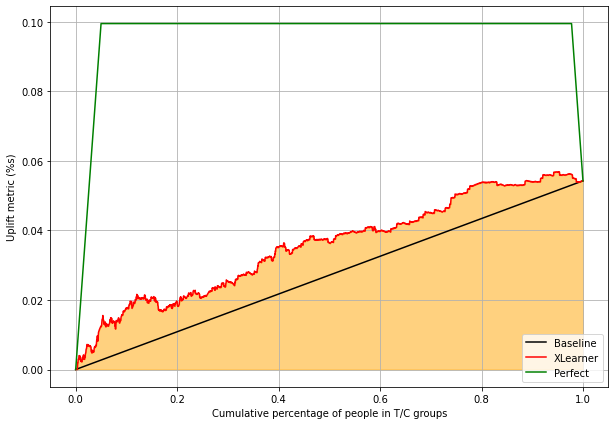

In [17]:
plt.figure(figsize=(10, 7))

plt.plot(xs_base, ys_base, 'black')
plt.plot(xs_xlearner, ys_xlearner, 'red')
plt.plot(xs_perfect, ys_perfect, 'green')

plt.fill_between(xs_xlearner, ys_xlearner, alpha=0.5, color='orange')

plt.xlabel('Cumulative percentage of people in T/C groups')
plt.ylabel('Uplift metric (%s)'.format(UPLIFT_METRIC))
plt.grid()
plt.legend(['Baseline', 'XLearner', 'Perfect']);

# Report

Train data shape: (4126, 125)
Feats was rejected during automatic roles guess: ['FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'NAME_TYPE_SUITE']


Layer 1 ...
Train process start. Time left 9999999999.077793 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
Linear model: C = 1e-05 score = 0.6811692927378272
Linear model: C = 5e-05 score = 0.7071585120246417
Linear model: C = 0.0001 score = 0.7262320815069304
Linear model: C = 0.0005 score = 0.7715318090273664
Linear model: C = 0.001 score = 0.7800616040753465
Linear model: C = 0.005 score = 0.7778847292974767
Linear model: C = 0.01 score = 0.7718872171543656
Linear model: C = 1e-05 score = 0.6514507291074048
Linear model: C = 5e-05 score = 0.6661975626553283
Linear model: C = 0.0001 score = 0.6793574273138305
Linear model: C = 0.0005 score = 0.7096445788543881
Linear model: C = 0.001 score = 0.7198850196125401
Linear model: C = 0.005 score = 0

(array([ 0.03579801,  0.050707  ,  0.00819561, ..., -0.01529248,
         0.0715549 ,  0.06681152], dtype=float32),
 array([0.08295936, 0.08791099, 0.02465368, ..., 0.08157068, 0.12309559,
        0.11612513], dtype=float32),
 array([0.04716135, 0.037204  , 0.01645806, ..., 0.09686317, 0.05154068,
        0.0493136 ], dtype=float32))

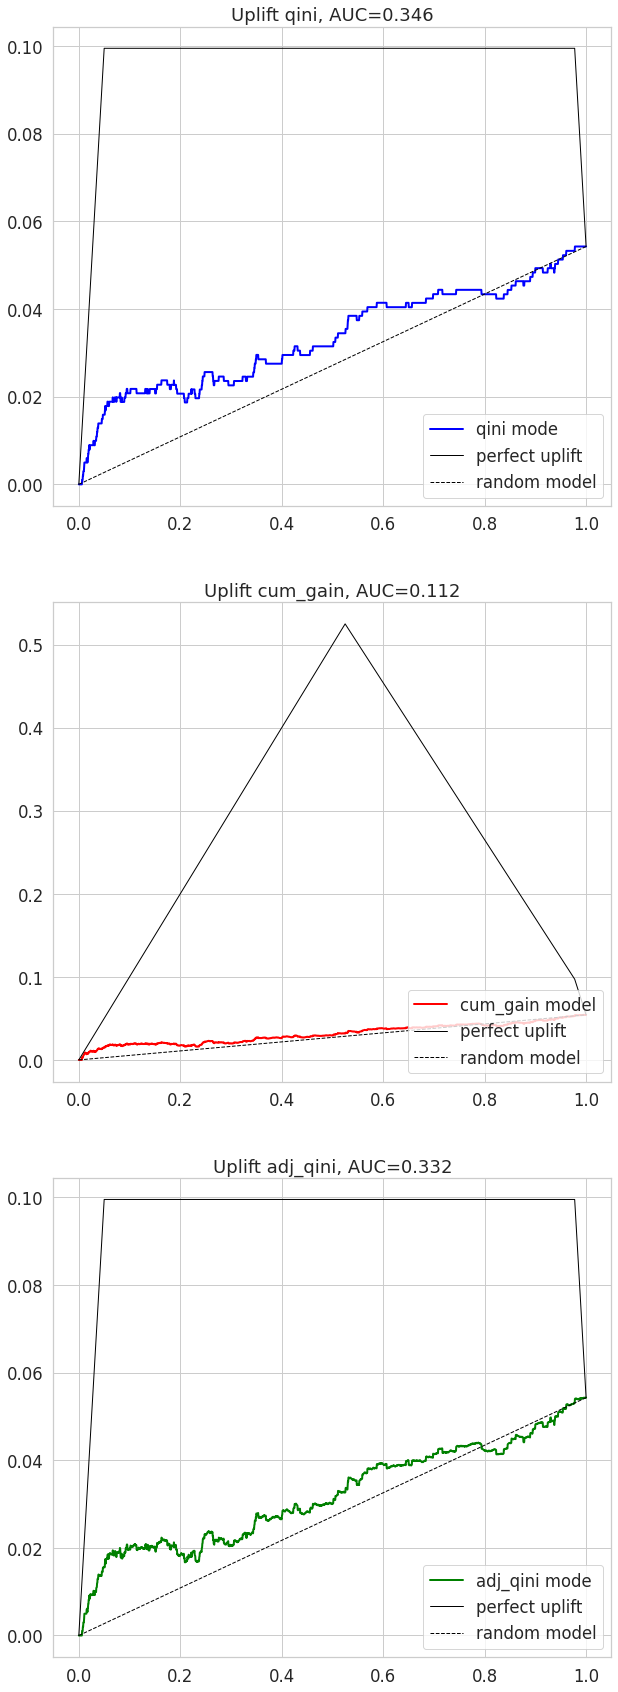

In [18]:
%%time

RDU = ReportDecoUplift()
tlearner_deco = RDU(meta_learners.TLearner(base_task=Task('binary')))
tlearner_deco.fit(train, roles)
tlearner_deco.predict(test);

# Path to report: PATH_TO_CURRENT_NOTEBOOK/lama_report/lama_interactive_report.html